In [ ]:
import numpy as np
import os
import torch
from torchvision.transforms import Compose, ToTensor, Normalize
from PIL import Image
import matplotlib.pyplot as plt
import cv2
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 901.3/901.3 kB 17.3 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
model = YOLO('yolov8n.pt') #asta e deja antrenata
results = model('imagine.jpg')
processed_image = results[0].plot()

output_path = 'outputs/imagine_detectata.jpg'
Image.fromarray(processed_image).save(output_path)


image 1/1 /home/lolluckestar/Desktop/M1/Computer-Vision/Lab6/imagine.jpg: 448x640 43 cars, 1 bus, 2 trucks, 53.6ms
Speed: 1.5ms preprocess, 53.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


In [ ]:
model = YOLO('yolov8n.pt')

results = model('download.jpeg')
detections = results[0].boxes.data #luam datele din fiecare box

person_class = 0
num_persons = sum(1 for det in detections if int(det[5]) == person_class) #aici numara clasele (indexul din comon object context)

print(f"Numărul de persoane detectate: {num_persons}")

processed_image = results[0].plot()
output_path = 'outputs/imagine_persoana_detectata.jpg'
Image.fromarray(processed_image).save(output_path)


image 1/1 /home/lolluckestar/Desktop/M1/Computer-Vision/Lab6/download.jpeg: 640x448 3 persons, 1 tie, 68.2ms
Speed: 2.5ms preprocess, 68.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)
Numărul de persoane detectate: 3


In [ ]:
from operator import itemgetter

model = YOLO('yolov8n.pt')
videoPath = 'crowd.mp4'

cap = cv2.VideoCapture(videoPath) #am clasa pentru capture intializata cu mp4-ul meu
fourcc = cv2.VideoWriter_fourcc(*'mp4v') #descopunere in caracter
fps = int(cap.get(cv2.CAP_PROP_FPS)) #pt a pastra fps constant - cadre sec
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) #width
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))#height
out = cv2.VideoWriter('output.mp4', fourcc, fps, (frame_width, frame_height)) #obiectul de write

while cap.isOpened:
    ret,frame = cap.read()
    if not ret: #daca mai am cadre de citit asta arata - un flag
        break

    prediction = model(frame)
    detection = prediction[0].boxes.data

    if len(detection) > 0:
        detections = sorted(detection,key=itemgetter(4),reverse=True) #sortare dupa cele mai mari elemente -nr 4 adica confidence
        top_detections = detections[:4] #aici numa 4 bounding boxes

        for det in top_detections:
            x1, y1, x2, y2, conf, cls = map(float, det) #le mapam
            label = f"{model.names[int(cls)]} {conf:.2f}" #scoatem label-ul - numele lor
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
            cv2.putText(frame, label, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, (0, 255, 0), 2)
    out.write(frame)

    cv2.imshow('YOLO Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()





0: 384x640 18 persons, 19.9ms
Speed: 1.8ms preprocess, 19.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 14 persons, 19.3ms
Speed: 1.5ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 persons, 19.3ms
Speed: 1.5ms preprocess, 19.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 19.4ms
Speed: 2.0ms preprocess, 19.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 21 persons, 19.4ms
Speed: 2.1ms preprocess, 19.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 25 persons, 19.3ms
Speed: 1.5ms preprocess, 19.3ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 22 persons, 1 bus, 19.3ms
Speed: 1.6ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 persons, 19.3ms
Speed: 1.9ms preprocess, 19.3ms inference, 1.1ms postprocess per i

In [ ]:
import cv2
import os
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator, colors

model = YOLO("yolo11n-seg.pt")

frames_path = "data/images"
output_folder = "output5"
output_video = "tracked_video.avi"

os.makedirs(output_folder, exist_ok=True)

frame_files = sorted([os.path.join(frames_path, f) for f in os.listdir(frames_path) if f.endswith(".PNG")])

im0 = cv2.imread(frame_files[0])
h, w, _ = im0.shape
fps = 30

out = cv2.VideoWriter(output_video, cv2.VideoWriter_fourcc(*"MJPG"), fps, (w, h))

tracked_vehicle_id = None
entry_frame = None
exit_frame = None

total_objects = 0
correct_detections = 0
iou_threshold = 0.5

def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    inter_x1 = max(x1, x1_p)
    inter_y1 = max(y1, y1_p)
    inter_x2 = min(x2, x2_p)
    inter_y2 = min(y2, y2_p)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)

    union_area = box1_area + box2_area - inter_area

    if union_area == 0:
        return 0
    return inter_area / union_area

for frame_idx, frame_file in enumerate(frame_files):
    im0 = cv2.imread(frame_file)
    annotator = Annotator(im0, line_width=2)

    results = model.track(im0, persist=True)

    if results[0].boxes.id is not None and results[0].masks is not None:
        boxes = results[0].boxes.xyxy.cpu().numpy()
        track_ids = results[0].boxes.id.int().cpu().tolist()
        class_ids = results[0].boxes.cls.int().cpu().tolist()
        masks = results[0].masks.xy

        for mask, track_id, class_id in zip(masks, track_ids, class_ids):
            if tracked_vehicle_id is None and track_id == 1:
                tracked_vehicle_id = track_id
                entry_frame = frame_idx

            if track_id == tracked_vehicle_id:
                color = colors(int(track_id), True)
                txt_color = annotator.get_txt_color(color)
                annotator.seg_bbox(mask=mask, mask_color=color, label=f"Tracked {track_id}", txt_color=txt_color)
                exit_frame = frame_idx

            else:
                color = colors(int(track_id), True)
                annotator.seg_bbox(mask=mask, mask_color=color, label=str(track_id))

    output_file = os.path.join(output_folder, f"frame_{frame_idx:04d}.png")
    cv2.imwrite(output_file, im0)

    out.write(im0)

    print(f"Frame {frame_idx} procesat și salvat în {output_file}")

out.release()
print("Procesarea s-a încheiat.")
if tracked_vehicle_id is not None:
    print(f"Tracked vehicle {tracked_vehicle_id}: Entered at frame {entry_frame}, exited at frame {exit_frame}")
else:
    print("No vehicle was tracked.")

cap = cv2.VideoCapture(output_video)
if not cap.isOpened():
    print("Eroare la deschiderea videoclipului rezultat!")
else:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imshow("Tracked Video", frame)
        if cv2.waitKey(30) & 0xFF == ord("q"):
            break
cap.release()
cv2.destroyAllWindows()



0: 384x640 8 cars, 28.1ms
Speed: 1.8ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Frame 0 procesat și salvat în output5/frame_0000.png

0: 384x640 6 cars, 1 truck, 27.6ms
Speed: 1.9ms preprocess, 27.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Frame 1 procesat și salvat în output5/frame_0001.png

0: 384x640 7 cars, 27.7ms
Speed: 2.1ms preprocess, 27.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Frame 2 procesat și salvat în output5/frame_0002.png

0: 384x640 7 cars, 27.6ms
Speed: 1.9ms preprocess, 27.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)
Frame 3 procesat și salvat în output5/frame_0003.png

0: 384x640 7 cars, 27.6ms
Speed: 1.9ms preprocess, 27.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Frame 4 procesat și salvat în output5/frame_0004.png

0: 384x640 7 cars, 27.6ms
Speed: 1.7ms preprocess, 27.6ms inference, 2.3ms postprocess per image at shape

In [ ]:
import os
import xml.etree.ElementTree as ET

annotations_path = "/content/drive/MyDrive/data/annotations.xml"
raw_frames_path = "/content/drive/MyDrive/data/images"
output_dir = "/content/drive/MyDrive/data/yolo_dataset"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

os.makedirs(os.path.join(train_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(train_dir, "labels"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "images"), exist_ok=True)
os.makedirs(os.path.join(test_dir, "labels"), exist_ok=True)

tree = ET.parse(annotations_path)
root = tree.getroot()

def convert_to_yolo_format(box, image_width, image_height):
    xtl, ytl, xbr, ybr = float(box["xtl"]), float(box["ytl"]), float(box["xbr"]), float(box["ybr"])
    x_center = ((xtl + xbr) / 2) / image_width
    y_center = ((ytl + ybr) / 2) / image_height
    width = (xbr - xtl) / image_width
    height = (ybr - ytl) / image_height
    return f"{x_center} {y_center} {width} {height}"

for track in root.findall("track"):
    label = track.attrib["label"]
    if label not in ["car", "minivan"]:
        continue
    class_id = 0 if label == "car" else 1

    for box in track.findall("box"):
        frame = int(box.attrib["frame"])
        if int(box.attrib["outside"]) == 1:
            continue

        image_file = f"frame_{frame:06d}.PNG"
        split = train_dir if frame % 10 < 7 else test_dir

        label_file = os.path.join(split, "labels", f"{image_file.replace('.PNG', '.txt')}")
        with open(label_file, "a") as f:
            yolo_line = convert_to_yolo_format(box.attrib, 1920, 1080)
            f.write(f"{class_id} {yolo_line}\n")

print("Dataset preparation complete.")


Dataset preparation complete.


In [ ]:
from ultralytics import YOLO

train_images_dir = "/content/drive/MyDrive/data/yolo_dataset/train/images"
test_images_dir = "/content/drive/MyDrive/data/yolo_dataset/test/images"
data_yaml_path = "/content/drive/MyDrive/data/yolo_dataset/data.yaml"

data_yaml_content = f"""
path: /content/drive/MyDrive/data/yolo_dataset
train: train/images
val: test/images

nc: 2
names: ['car', 'minivan']
"""
with open(data_yaml_path, "w") as f:
    f.write(data_yaml_content)

print("data.yaml created successfully:")
print(data_yaml_content)

if not os.listdir(train_images_dir) or not os.listdir(test_images_dir):
    raise FileNotFoundError("Imaginile sau etichetele lipsesc!")

model = YOLO("yolov8m.pt")

print("Starting warm-up phase...")
model.train(
    data=data_yaml_path,
    epochs=5,
    imgsz=1280,
    batch=16,
    lr0=1e-4,
    freeze=10,
    mosaic=0.5,
    verbose=True
)

print("Starting fine-tuning phase...")
model.train(
    data=data_yaml_path,
    epochs=20,
    imgsz=1280,
    batch=16,
    lr0=1e-3,
    freeze=0,
    mosaic=1.0,
    mixup=0.2,
    optimizer="Adam",
    verbose=True,
    val = True
)

print("\nRunning evaluation on the test set...")
metrics = model.val()

print("\nEvaluation Results:")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")


data.yaml created successfully:

path: /content/drive/MyDrive/data/yolo_dataset
train: train/images
val: test/images

nc: 2
names: ['car', 'minivan']



100%|██████████| 49.7M/49.7M [00:00<00:00, 252MB/s]


Starting warm-up phase...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/data/yolo_dataset/data.yaml, epochs=5, time=None, patience=100, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, 

100%|██████████| 755k/755k [00:00<00:00, 13.8MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 62.7MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/data/yolo_dataset/train/labels.cache... 301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 301/301 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000028.PNG: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000030.PNG: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000031.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000032.PNG: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000033.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000034.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000035.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000036.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/drive/MyDrive/data/yolo_dataset/test/labels.cache... 299 images, 0 backgrounds, 0 corrupt: 100%|██████████| 299/299 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000027.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000028.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000029.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000037.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000038.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000039.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000047.PNG: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000048.PNG: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000049.PNG: 3

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5      10.9G      0.578      2.405     0.8612        218       1280: 100%|██████████| 19/19 [00:11<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

                   all        299       1397      0.182      0.928      0.205       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      11.5G     0.4695     0.6927     0.8238        322       1280: 100%|██████████| 19/19 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


                   all        299       1397      0.369      0.944      0.364      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5      10.1G      0.452     0.6554     0.8211        340       1280: 100%|██████████| 19/19 [00:04<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]

                   all        299       1397      0.361      0.949      0.364      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5      10.4G     0.4299     0.5224     0.8184        309       1280: 100%|██████████| 19/19 [00:04<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        299       1397      0.366      0.947      0.368      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5        10G     0.4065     0.4957     0.8142        248       1280: 100%|██████████| 19/19 [00:04<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.12it/s]

                   all        299       1397      0.366      0.954       0.37      0.343



5 epochs completed in 0.019 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.1MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 218 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.82it/s]


                   all        299       1397      0.366      0.954      0.372      0.344
                   car        281       1305      0.352      0.929      0.351       0.32
               minivan         90         92       0.38      0.978      0.393      0.369
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train
Starting fine-tuning phase...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/drive/MyDrive/data/yolo_dataset/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale

train: Scanning /content/drive/MyDrive/data/yolo_dataset/train/labels.cache... 301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 301/301 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000028.PNG: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000030.PNG: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000031.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000032.PNG: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000033.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000034.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000035.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000036.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train


val: Scanning /content/drive/MyDrive/data/yolo_dataset/test/labels.cache... 299 images, 0 backgrounds, 0 corrupt: 100%|██████████| 299/299 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000027.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000028.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000029.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000037.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000038.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000039.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000047.PNG: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000048.PNG: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000049.PNG: 3

Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      27.2G     0.4538     0.5078     0.8308        409       1280: 100%|██████████| 19/19 [00:08<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        299       1397      0.368      0.944      0.377      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20        26G     0.4625     0.5269     0.8282        309       1280: 100%|██████████| 19/19 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        299       1397       0.37      0.942      0.369      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      25.7G      0.434     0.4671     0.8229        390       1280: 100%|██████████| 19/19 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        299       1397      0.371       0.95      0.369      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      27.8G     0.4179      0.467     0.8178        416       1280: 100%|██████████| 19/19 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        299       1397      0.369      0.941      0.386      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20        26G     0.4274     0.4608     0.8229        372       1280: 100%|██████████| 19/19 [00:07<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        299       1397      0.363      0.942      0.382      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      25.4G     0.4233     0.4856     0.8194        370       1280: 100%|██████████| 19/19 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        299       1397      0.368      0.949      0.377      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      25.3G     0.4059      0.425      0.815        419       1280: 100%|██████████| 19/19 [00:07<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        299       1397      0.367      0.943      0.377      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      26.1G     0.3858      0.436     0.8121        296       1280: 100%|██████████| 19/19 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        299       1397      0.367      0.952      0.379      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      27.4G     0.3835     0.4203     0.8116        409       1280: 100%|██████████| 19/19 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        299       1397      0.369      0.949      0.379      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      25.5G     0.3703     0.3981     0.8014        376       1280: 100%|██████████| 19/19 [00:07<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        299       1397       0.37      0.949      0.375      0.361


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      26.7G     0.3233     0.4008     0.7892        175       1280: 100%|██████████| 19/19 [00:10<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        299       1397      0.371      0.951      0.373      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      26.7G     0.3211     0.3986     0.7872        198       1280: 100%|██████████| 19/19 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        299       1397      0.371      0.951      0.379      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      27.5G     0.3145     0.3896     0.7888        197       1280: 100%|██████████| 19/19 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.40it/s]

                   all        299       1397      0.369      0.941       0.39      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      26.7G     0.3084     0.3868     0.7925        203       1280: 100%|██████████| 19/19 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        299       1397      0.372       0.95      0.378      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      26.7G     0.3021     0.3703     0.7853        222       1280: 100%|██████████| 19/19 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.35it/s]

                   all        299       1397      0.373      0.951       0.38      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      26.8G     0.2967     0.3649     0.7833        172       1280: 100%|██████████| 19/19 [00:07<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        299       1397       0.37      0.952      0.377      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      27.5G     0.2813     0.3609     0.7826        153       1280: 100%|██████████| 19/19 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.43it/s]

                   all        299       1397       0.37      0.951       0.38      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      26.7G     0.2772     0.3523     0.7812        198       1280: 100%|██████████| 19/19 [00:07<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        299       1397      0.371      0.949      0.377      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      26.7G     0.2693      0.351     0.7766        188       1280: 100%|██████████| 19/19 [00:07<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.53it/s]

                   all        299       1397       0.37      0.949      0.379       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      26.8G      0.268      0.345     0.7757        161       1280: 100%|██████████| 19/19 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        299       1397       0.37      0.948      0.377      0.369



20 epochs completed in 0.077 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 52.1MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 52.1MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 218 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


                   all        299       1397      0.369      0.941       0.39      0.377
                   car        281       1305      0.358      0.914      0.356       0.34
               minivan         90         92       0.38      0.967      0.423      0.413
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/train2

Running evaluation on the test set...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 218 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/drive/MyDrive/data/yolo_dataset/test/labels.cache... 299 images, 0 backgrounds, 0 corrupt: 100%|██████████| 299/299 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000027.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000028.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000029.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000037.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000038.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000039.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000047.PNG: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000048.PNG: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000049.PNG: 3


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.57it/s]


                   all        299       1397      0.369      0.941      0.392      0.379
                   car        281       1305      0.358      0.915      0.355      0.341
               minivan         90         92       0.38      0.967      0.428      0.418
Speed: 0.4ms preprocess, 5.8ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/train22

Evaluation Results:
mAP50: 0.3916
mAP50-95: 0.3794


In [ ]:
from ultralytics import YOLO

data_yaml_path = "/content/drive/MyDrive/data/yolo_dataset/data.yaml"

model = YOLO("yolov8n.pt")
print("Starting training...")

model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    optimizer="Adam",
    val=True
)

print("Training complete.")


100%|██████████| 6.25M/6.25M [00:00<00:00, 73.7MB/s]


Starting training...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/data/yolo_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sa

train: Scanning /content/drive/MyDrive/data/yolo_dataset/train/labels.cache... 301 images, 0 backgrounds, 0 corrupt: 100%|██████████| 301/301 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000028.PNG: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000030.PNG: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000031.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000032.PNG: 1 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000033.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000034.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000035.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train/images/frame_000036.PNG: 2 duplicate labels removed
train: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/train


val: Scanning /content/drive/MyDrive/data/yolo_dataset/test/labels.cache... 299 images, 0 backgrounds, 0 corrupt: 100%|██████████| 299/299 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000027.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000028.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000029.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000037.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000038.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000039.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000047.PNG: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000048.PNG: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000049.PNG: 3

Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.67G      1.166      2.234     0.9298        297        640: 100%|██████████| 19/19 [00:03<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.15it/s]

                   all        299       1397     0.0194      0.517     0.0948     0.0538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.39G     0.9725      1.039     0.8749        338        640: 100%|██████████| 19/19 [00:02<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


                   all        299       1397     0.0656     0.0207     0.0219     0.0134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.73G     0.9062     0.8142     0.8641        324        640: 100%|██████████| 19/19 [00:02<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]

                   all        299       1397     0.0754      0.294     0.0482     0.0182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.57G      0.949     0.8074      0.873        333        640: 100%|██████████| 19/19 [00:02<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.84it/s]

                   all        299       1397     0.0924      0.304      0.063     0.0327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.48G     0.9362     0.7487     0.8671        384        640: 100%|██████████| 19/19 [00:02<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.60it/s]

                   all        299       1397      0.278      0.328      0.178      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.38G     0.9066     0.7475     0.8614        250        640: 100%|██████████| 19/19 [00:02<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]

                   all        299       1397       0.27      0.628      0.287      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.55G     0.8348     0.6855     0.8541        298        640: 100%|██████████| 19/19 [00:02<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.75it/s]

                   all        299       1397      0.206      0.794      0.309      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.72G     0.8003     0.6689     0.8567        305        640: 100%|██████████| 19/19 [00:02<00:00,  7.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]

                   all        299       1397      0.356      0.813      0.373      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.54G     0.7745     0.6616     0.8433        281        640: 100%|██████████| 19/19 [00:03<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]

                   all        299       1397      0.362      0.883      0.392      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.56G     0.8077     0.6532     0.8408        238        640: 100%|██████████| 19/19 [00:02<00:00,  6.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.94it/s]

                   all        299       1397       0.36      0.883      0.381        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.4G     0.7815     0.6208     0.8422        397        640: 100%|██████████| 19/19 [00:02<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]

                   all        299       1397       0.36      0.852      0.379      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.59G     0.7417     0.6215     0.8329        319        640: 100%|██████████| 19/19 [00:02<00:00,  7.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]

                   all        299       1397      0.367      0.893      0.387      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.67G     0.6998     0.6072     0.8301        217        640: 100%|██████████| 19/19 [00:02<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]

                   all        299       1397      0.366      0.876       0.39      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.51G     0.6657      0.577     0.8241        309        640: 100%|██████████| 19/19 [00:02<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.50it/s]

                   all        299       1397      0.367      0.888      0.383      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.68G     0.6837     0.5766     0.8294        327        640: 100%|██████████| 19/19 [00:03<00:00,  5.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.85it/s]

                   all        299       1397      0.358      0.878      0.384      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.63G     0.6733     0.5762     0.8219        477        640: 100%|██████████| 19/19 [00:02<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.72it/s]

                   all        299       1397      0.353        0.9      0.368      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.56G     0.6336      0.571     0.8229        375        640: 100%|██████████| 19/19 [00:02<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]

                   all        299       1397      0.365      0.927      0.367      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.73G     0.6263     0.5775     0.8158        348        640: 100%|██████████| 19/19 [00:02<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.42it/s]

                   all        299       1397      0.368      0.919      0.385      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.55G     0.6003     0.5353     0.8195        250        640: 100%|██████████| 19/19 [00:03<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]

                   all        299       1397      0.367      0.881      0.372      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.86G     0.5832     0.5204     0.8115        252        640: 100%|██████████| 19/19 [00:03<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]

                   all        299       1397      0.367      0.898      0.368      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.69G     0.5621     0.5043     0.8116        371        640: 100%|██████████| 19/19 [00:02<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]

                   all        299       1397      0.366       0.91      0.398      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.76G     0.5751     0.5085     0.8094        442        640: 100%|██████████| 19/19 [00:02<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.60it/s]

                   all        299       1397      0.371      0.917      0.397      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.46G     0.5722     0.5255     0.8192        250        640: 100%|██████████| 19/19 [00:02<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]

                   all        299       1397      0.369      0.899      0.377      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.96G     0.5621     0.5306      0.808        227        640: 100%|██████████| 19/19 [00:02<00:00,  6.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.79it/s]

                   all        299       1397      0.367      0.908      0.375      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.39G     0.5562     0.5267     0.8155        296        640: 100%|██████████| 19/19 [00:02<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]

                   all        299       1397      0.369      0.914      0.371      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.41G     0.5533     0.5131     0.8095        351        640: 100%|██████████| 19/19 [00:02<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]

                   all        299       1397      0.365      0.927      0.374      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.75G     0.5244     0.4851     0.8079        379        640: 100%|██████████| 19/19 [00:02<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.71it/s]

                   all        299       1397      0.367      0.921      0.364      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.84G     0.5168     0.4851     0.8067        349        640: 100%|██████████| 19/19 [00:03<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.59it/s]

                   all        299       1397      0.365      0.879      0.363      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.58G     0.5266     0.5125     0.8053        389        640: 100%|██████████| 19/19 [00:02<00:00,  6.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]

                   all        299       1397      0.366      0.909      0.375      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.48G     0.5245     0.4967     0.8084        446        640: 100%|██████████| 19/19 [00:02<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.83it/s]

                   all        299       1397      0.369      0.879      0.383      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.76G     0.5108     0.4749     0.8033        321        640: 100%|██████████| 19/19 [00:02<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.57it/s]

                   all        299       1397      0.368      0.899      0.372      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.76G     0.5154     0.4767     0.8062        305        640: 100%|██████████| 19/19 [00:03<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.37it/s]

                   all        299       1397      0.367        0.9      0.374      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.75G     0.4903     0.4623      0.802        352        640: 100%|██████████| 19/19 [00:03<00:00,  5.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.46it/s]

                   all        299       1397      0.363      0.926       0.38      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.64G     0.4698     0.4602     0.7979        312        640: 100%|██████████| 19/19 [00:02<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]

                   all        299       1397      0.367      0.922       0.38      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.74G     0.4902     0.4647     0.8052        393        640: 100%|██████████| 19/19 [00:02<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.53it/s]

                   all        299       1397      0.368      0.906      0.375      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50       2.5G     0.4742     0.4677     0.7996        313        640: 100%|██████████| 19/19 [00:03<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.92it/s]

                   all        299       1397      0.369      0.908      0.381      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.74G     0.4766     0.4633     0.7993        292        640: 100%|██████████| 19/19 [00:03<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.91it/s]

                   all        299       1397      0.367      0.896      0.384      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.38G     0.4793      0.461     0.7997        350        640: 100%|██████████| 19/19 [00:02<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]

                   all        299       1397      0.368      0.884      0.371      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       2.7G     0.4723     0.4666        0.8        308        640: 100%|██████████| 19/19 [00:02<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.94it/s]

                   all        299       1397      0.366      0.902      0.374      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.49G     0.4625     0.4469     0.7983        306        640: 100%|██████████| 19/19 [00:02<00:00,  6.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]

                   all        299       1397      0.369      0.909      0.386      0.352


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.27G     0.4324     0.4523     0.7813        211        640: 100%|██████████| 19/19 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]

                   all        299       1397      0.367      0.908      0.372      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.37G     0.4284     0.4514     0.7783        194        640: 100%|██████████| 19/19 [00:02<00:00,  6.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]

                   all        299       1397      0.368      0.921      0.373      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.38G     0.4284     0.4381      0.783        174        640: 100%|██████████| 19/19 [00:03<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.70it/s]

                   all        299       1397      0.365      0.926      0.371       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.38G     0.4087     0.4391     0.7879        179        640: 100%|██████████| 19/19 [00:03<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.85it/s]

                   all        299       1397      0.369       0.92      0.374      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.37G     0.4033     0.4338     0.7843        185        640: 100%|██████████| 19/19 [00:02<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]

                   all        299       1397       0.37       0.92      0.382      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.38G     0.3982     0.4265      0.782        187        640: 100%|██████████| 19/19 [00:02<00:00,  7.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]

                   all        299       1397       0.37       0.92      0.379      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.37G     0.3916     0.4222      0.778        183        640: 100%|██████████| 19/19 [00:02<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.68it/s]

                   all        299       1397       0.37      0.918      0.382      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.29G     0.3831     0.4098     0.7823        178        640: 100%|██████████| 19/19 [00:02<00:00,  7.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.43it/s]

                   all        299       1397       0.37      0.918      0.382      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.37G     0.3716     0.4097     0.7812        193        640: 100%|██████████| 19/19 [00:03<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.62it/s]

                   all        299       1397       0.37      0.917      0.381      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.37G     0.3768     0.4061     0.7791        211        640: 100%|██████████| 19/19 [00:02<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.93it/s]

                   all        299       1397       0.37      0.914      0.382      0.355



50 epochs completed in 0.123 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.51 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


                   all        299       1397       0.37      0.914      0.383      0.356
                   car        281       1305      0.356      0.851      0.353       0.32
               minivan         90         92      0.384      0.977      0.414      0.392
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/train3
Training complete.


In [ ]:
import cv2
import os
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")

test_images_path = "/content/drive/MyDrive/data/yolo_dataset/test/images"
output_dir = "/content/drive/MyDrive/data/task6_inference"
os.makedirs(output_dir, exist_ok=True)

correct_cars = 0
total_cars = 0

print("Running inference...")
for image_file in os.listdir(test_images_path):
    image_path = os.path.join(test_images_path, image_file)
    results = model.predict(source=image_path, save=False, show=False)

    label_file = os.path.join(test_images_path.replace("images", "labels"), image_file.replace(".PNG", ".txt"))
    with open(label_file, "r") as f:
        ground_truths = [line.strip().split() for line in f.readlines()]
        car_count_gt = sum(1 for gt in ground_truths if int(gt[0]) == 0)

    detections = results[0].boxes
    if detections is not None:
        class_ids = detections.cls.cpu().numpy()
        detected_cars = sum(1 for cls in class_ids if cls == 0)
        correct_cars += min(detected_cars, car_count_gt)
        total_cars += car_count_gt

    annotated_image = results[0].plot()
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, annotated_image)

accuracy = (correct_cars / total_cars * 100) if total_cars > 0 else 0

metrics = model.val()

# Afișare rezultate
print("\nEvaluation Results:")
print(f"Correctly identified cars: {correct_cars}/{total_cars} ({accuracy:.2f}%)")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Inference results saved to {output_dir}.")


Running inference...

image 1/1 /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000128.PNG: 736x1280 11 cars, 1 minivan, 61.7ms
Speed: 6.5ms preprocess, 61.7ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000059.PNG: 736x1280 11 cars, 9.8ms
Speed: 6.3ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000037.PNG: 736x1280 9 cars, 9.8ms
Speed: 6.5ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000130.PNG: 736x1280 11 cars, 1 minivan, 10.4ms
Speed: 6.3ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000197.PNG: 736x1280 14 cars, 1 minivan, 10.4ms
Speed: 6.3ms preprocess,

val: Scanning /content/drive/MyDrive/data/yolo_dataset/test/labels.cache... 299 images, 0 backgrounds, 0 corrupt: 100%|██████████| 299/299 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000027.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000028.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000029.PNG: 1 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000037.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000038.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000039.PNG: 2 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000047.PNG: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000048.PNG: 3 duplicate labels removed
val: WARNING ⚠️ /content/drive/MyDrive/data/yolo_dataset/test/images/frame_000049.PNG: 3


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.65it/s]


                   all        299       1397      0.366      0.954      0.368      0.343
                   car        281       1305      0.352       0.93      0.351      0.321
               minivan         90         92       0.38      0.978      0.386      0.365
Speed: 0.3ms preprocess, 5.0ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs/detect/val

Evaluation Results:
Correctly identified cars: 1255/1428 (87.89%)
mAP50: 0.3684
mAP50-95: 0.3429
Inference results saved to /content/drive/MyDrive/data/task6_inference.


Afișare imagini diverse cu detecții YOLO:

0: 736x1280 12 cars, 1 minivan, 12.6ms
Speed: 7.8ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 13 cars, 1 minivan, 10.6ms
Speed: 6.8ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 10 cars, 10.1ms
Speed: 6.5ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 10 cars, 1 minivan, 15.4ms
Speed: 9.9ms preprocess, 15.4ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 9 cars, 12.8ms
Speed: 6.8ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


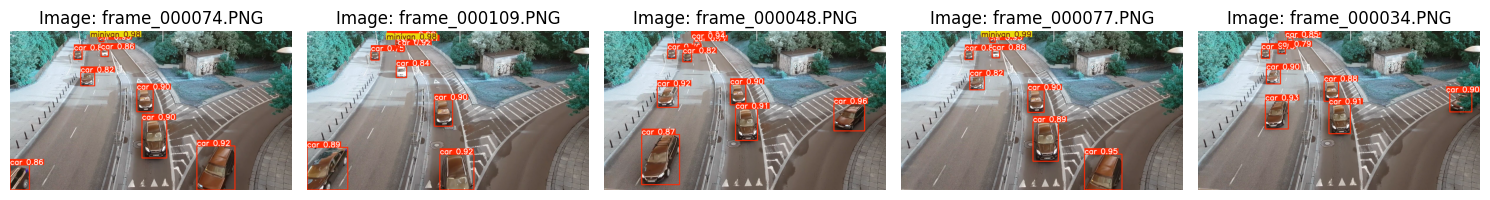

In [ ]:
import matplotlib.pyplot as plt
import random
import cv2

def display_random_detections(model, images_dir, num_images=5):
    image_files = random.sample(os.listdir(images_dir), num_images)
    plt.figure(figsize=(15, 15))

    for idx, image_file in enumerate(image_files):
        image_path = os.path.join(images_dir, image_file)
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = model(image)
        annotated_image = results[0].plot()

        plt.subplot(1, num_images, idx + 1)
        plt.imshow(annotated_image)
        plt.axis("off")
        plt.title(f"Image: {image_file}")

    plt.tight_layout()
    plt.show()

print("Afișare imagini diverse cu detecții YOLO:")
display_random_detections(model, test_images_dir, num_images=5)

In [ ]:
print("\nEvaluation Results:")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")


Evaluation Results:
mAP50: 0.3684
mAP50-95: 0.3429
